# Regression Analysis of Spotify Song Popularity

### Overview

In this report, a machine learning model is used to predict the popularity of a song based on attributes such as song
title, artist, genre, and year. Training and test data are used to train and evaluate the model, respectively. A training dataset is used to
train the model, and a test dataset to test its performance. Test data predictions are made using the Random Forest Regressor
algorithm and thus we have not utilised Standard Scaler in the process
For regression, we refined the training data using *ColumnTransformer*, one-hot encoding, and Principal Component Analysis (PCA); then trained our model with *RandomForestRegressor*; Scikit-learn's *mean_squared_error* function returned an RMSE value of 5.06. 



In [44]:
# ALL LIBRARIES REQUIRED FOR ...

# ... Regression ...

import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error


import warnings
warnings.filterwarnings("ignore")


## 1. Regression Analysis

### 1.1 Pandas DataFrame for Regression

In [45]:
df = pd.read_csv('CS98XRegressionTrain.csv')

In [46]:
df.head()

,Id,title,artist,top genre,year,bpm,nrgy,dnce,dB,live,val,dur,acous,spch,pop
0,1,My Happiness,Connie Francis,adult standards,1996,107,31,45,-8,13,28,150,75,3,44
1,2,Unchained Melody,The Teddy Bears,NaN,2011,114,44,53,-8,13,47,139,49,3,37
2,3,How Deep Is Your Love,Bee Gees,adult standards,1979,105,36,63,-9,13,67,245,11,3,77
3,4,Woman in Love,Barbra Streisand,adult standards,1980,170,28,47,-16,13,33,232,25,3,67
4,5,Goodbye Yellow Brick Road - Remastered 2014,Elton John,glam rock,1973,121,47,56,-8,15,40,193,45,3,63


### 1.2 Data Refinement

In [47]:
# Loading the training data ...
train_data = pd.read_csv('CS98XRegressionTrain.csv')

In [48]:
# Now, we split the training data into features and target
train_features = train_data.drop(['Id', 'pop'], axis=1)
train_target = train_data['pop']

In [49]:
# Subsequently, we load the test data
test_data = pd.read_csv('CS98XRegressionTest.csv')

In [50]:
# Then we combine both the training and test data
combined_data = pd.concat([train_features, test_data.drop('Id', axis=1)])


Next, we used the Scikit-learn's *ColumnTransformer* class to preprocess our data. One-hot encoding enabled numeric conversion of the categorical attributes we chose as potential predictors: *title*, *artist*, *genre*, and *year*. 

We assume that songs grow popular as they are shared between listeners, and hypothesize that as such, familiar classics and hits will reflect their standing in the data. Certain decades, such as 80s and 90s, remain in the public consciousness and dance scene. 


In [51]:
# Preprocessing features with one-hot encoding ...

ct = ColumnTransformer(
    [('one_hot_encoder', OneHotEncoder(sparse=False), ['title', 'artist', 'top genre', 'year'])],
    remainder='passthrough'
)
combined_features = ct.fit_transform(combined_data)

To reduce dimensionality, we used PCA's *fit.transform()* function. This allowed for clearer visualizations, as shown in the histograms below.

In [52]:
# Apply PCA ...

pca = PCA(n_components=10)
combined_features = pca.fit_transform(combined_features)

array([[<AxesSubplot:title={'center':'Id'}>,
        <AxesSubplot:title={'center':'year'}>,
        <AxesSubplot:title={'center':'bpm'}>],
       [<AxesSubplot:title={'center':'nrgy'}>,
        <AxesSubplot:title={'center':'dnce'}>,
        <AxesSubplot:title={'center':'dB'}>],
       [<AxesSubplot:title={'center':'live'}>,
        <AxesSubplot:title={'center':'val'}>,
        <AxesSubplot:title={'center':'dur'}>],
       [<AxesSubplot:title={'center':'acous'}>,
        <AxesSubplot:title={'center':'spch'}>,
        <AxesSubplot:title={'center':'pop'}>]], dtype=object)

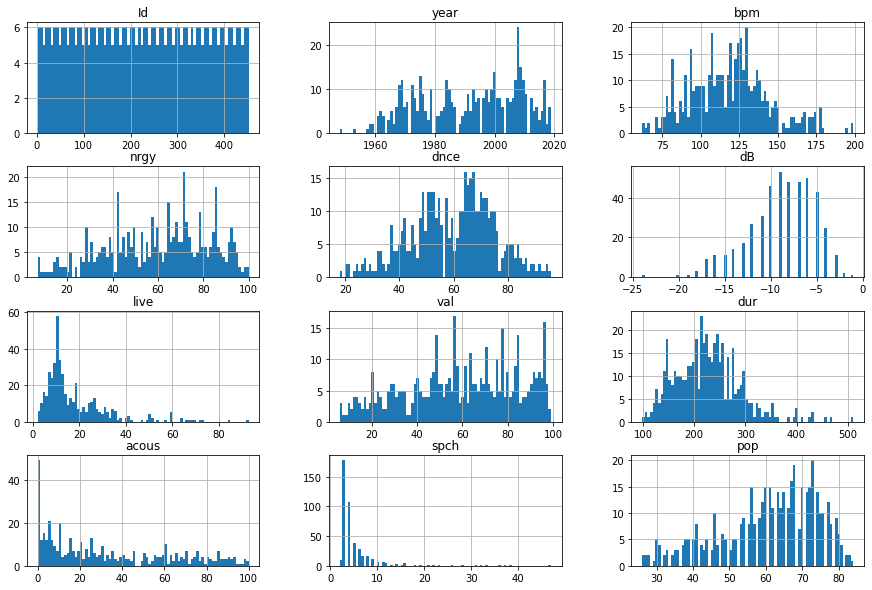

In [53]:
# Display histograms ...

df.hist(figsize=[15,10],bins=80)

In [54]:
# In order to separate training and test data, the transformed data is re-split.
# We do this before training our model. 

train_features = combined_features[:train_features.shape[0], :]
test_features = combined_features[train_features.shape[0]:, :]

### 1.3 Model Training

For our regression analysis, we use the Random Forest Regressor model on the premise that combined predictions will deliver better results for the Spotify dataset. Each attribute varies widely, meaning a singular approach is likely to skew, whereas a combined averaage will prevent such issues. 

In [55]:
# We then train the Random Forest Regressor model ...

rf_regressor = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)
rf_regressor.fit(train_features, train_target)

RandomForestRegressor(max_depth=10, random_state=42)

In [56]:
# To make predictions on test data ...

rf_test_predictions = rf_regressor.predict(test_features)

In [57]:
# Then we save the predictions as a file for the Kaggle competition
pd.DataFrame({'Id': test_data['Id'], 'pop': rf_test_predictions}).to_csv('CS98XGroup19MachineLearning.csv', index=False)

In [58]:
#Now, we calculate RMSE on training data through the Random Forest Regressor model ...

train_predictions = rf_regressor.predict(train_features)
train_rmse_rf = mean_squared_error(train_target, train_predictions, squared=False)

### 1.4 Visualisations 

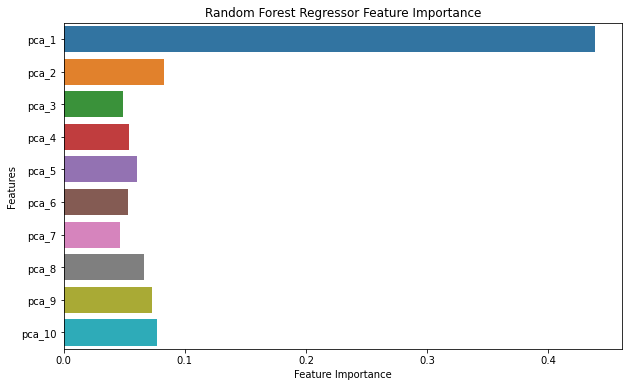

In [59]:
# Visualising through plot feature importance ...

train_features_df = pd.DataFrame(train_features, columns=[f'pca_{i+1}' for i in range(10)])
feature_importances = pd.Series(rf_regressor.feature_importances_, index=train_features_df.columns)
plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importances.values, y=feature_importances.index, orient='horizontal')
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Random Forest Regressor Feature Importance')
plt.show()

As we can see in the bar plot above, 'pca_1', 'pca_2', and 'pca_3' rank higher than the others in terms of feature importance. 'Pca_1' stands out as particularly significant. 

Below, a scatter plot shows the actual versus predicted values for song popularity, as applied to the training data. A plot showing the accuracy of the model's predictions shows some outliers.

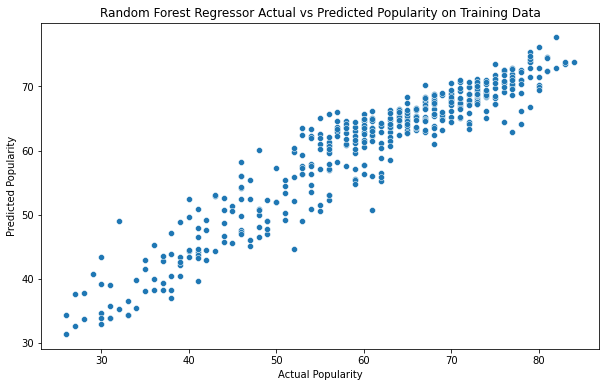

In [60]:
# Visualising through actual vs predicted values on training data ...

plt.figure(figsize=(10, 6))
sns.scatterplot(x=train_target, y=train_predictions)
plt.xlabel('Actual Popularity')
plt.ylabel('Predicted Popularity')
plt.title('Random Forest Regressor Actual vs Predicted Popularity on Training Data')
plt.show()

In [61]:
# Now, we print training RMSE for Random Forest Regressor model ...

print('Training RMSE (Random Forest Regressor):', train_rmse_rf)

Training RMSE (Random Forest Regressor): 5.063291195651614


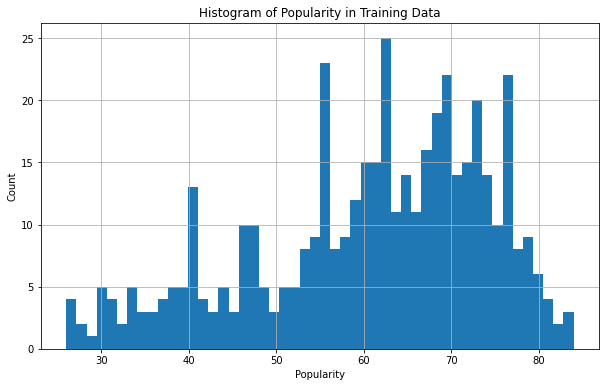

In [62]:
# Visualising through histogram of target variable ...

train_data['pop'].hist(bins=50, figsize=(10, 6))
plt.xlabel('Popularity')
plt.ylabel('Count')
plt.title('Histogram of Popularity in Training Data')
plt.show()

We use the histogram above to plot the target variable in the training data (popularity). As can be seen from the plot, the target variable distribution is skewed to the right.

Additionally, a heatmap is displayed to show the correlation matrix of the training data. In the heatmap, 'acousticness' and 'instrumentalness' are moderately positively correlated, while 'loudness' and 'popularity' are moderately negatively correlated.

In [63]:
# Visualising through example of the initial rows of the training data ...

print('First 5 rows of the training data:')
print(train_data.head())

First 5 rows of the training data:
   Id                                        title            artist  \
0   1                                 My Happiness    Connie Francis   
1   2                             Unchained Melody   The Teddy Bears   
2   3                        How Deep Is Your Love          Bee Gees   
3   4                                Woman in Love  Barbra Streisand   
4   5  Goodbye Yellow Brick Road - Remastered 2014        Elton John   

         top genre  year  bpm  nrgy  dnce  dB  live  val  dur  acous  spch  \
0  adult standards  1996  107    31    45  -8    13   28  150     75     3   
1              NaN  2011  114    44    53  -8    13   47  139     49     3   
2  adult standards  1979  105    36    63  -9    13   67  245     11     3   
3  adult standards  1980  170    28    47 -16    13   33  232     25     3   
4        glam rock  1973  121    47    56  -8    15   40  193     45     3   

   pop  
0   44  
1   37  
2   77  
3   67  
4   63  


In [64]:
# Then we conclude by highlighting the correlation matrix of training data ....

corr = train_data.corr().style.background_gradient(cmap='coolwarm')
corr.format('{:.2f}')
corr.set_properties(**{'font-size': '10pt', 'width': '100px'})
corr

,Id,year,bpm,nrgy,dnce,dB,live,val,dur,acous,spch,pop
Id,1.00,-0.03,0.06,0.04,0.04,-0.03,-0.04,0.04,0.06,-0.07,0.08,0.09
year,-0.03,1.00,-0.04,0.12,0.22,0.29,-0.00,-0.03,-0.05,-0.13,0.19,-0.05
bpm,0.06,-0.04,1.00,0.23,-0.01,0.10,0.02,0.15,0.03,-0.22,0.05,0.06
nrgy,0.04,0.12,0.23,1.00,0.35,0.68,0.10,0.42,0.18,-0.66,0.21,0.30
dnce,0.04,0.22,-0.01,0.35,1.00,0.25,-0.08,0.48,0.12,-0.40,0.24,0.26
dB,-0.03,0.29,0.10,0.68,0.25,1.00,0.08,0.16,0.10,-0.46,0.23,0.32
live,-0.04,-0.00,0.02,0.10,-0.08,0.08,1.00,0.07,-0.11,-0.02,0.09,-0.05
val,0.04,-0.03,0.15,0.42,0.48,0.16,0.07,1.00,-0.15,-0.25,0.08,-0.02
dur,0.06,-0.05,0.03,0.18,0.12,0.10,-0.11,-0.15,1.00,-0.28,0.10,0.36
acous,-0.07,-0.13,-0.22,-0.66,-0.40,-0.46,-0.02,-0.25,-0.28,1.00,-0.21,-0.47


Through this regression analysis, we determined that our chosen features, *title*, *artist*, *genre*, and *year*, work fairly well to predict song popularity on Spotify. An RMSE of 5.06 on the training data illustrates the reasonable prediction accuracy of the Random Forest Regressor model. 

Further investigation into what aspects of a song's musicality increase popularity (i.e. attributes *nrgy, dnce, live, acous*, and *spch*) could shed light on what earworms from different artists, genres, and eras have in common.

Bar plots are used to illustrate feature importance. In terms of importance, 'pca_1', 'pca_2', and 'pca_3' rank higher than the
others. On the training data, a scatter plot shows the actual versus predicted values. A plot showing the accuracy of the model's predictions shows some outliers. Histograms are used to plot the target variable in the training data (popularity). As can be seen from the plot, the target variable distribution is skewed to the right. Additionally, a heatmap is displayed to show the correlation matrix of the training data. In the heatmap, 'acousticness' and 'instrumentalness' are moderately positively correlated, while 'loudness' and 'popularity' are moderately negatively correlated.An RMSE of 5.06 on the training data illustrates the reasonable prediction accuracy of the Random Forest Regressor model.

